# Disease Predictor

This notebook implements a Multi-Label Text Classification model using Bert Preprocessor and Bert Encoders. The model in question will predict the disease a certain individiual may have based on the symptoms that he/she enters in text form.

# Importing Libraries

We are importing the required libraries now for preprocessing our data, building our model and saving our prediction classes.

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import sklearn.preprocessing
import json
import warnings

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
warnings.filterwarnings('ignore')

# Defining Hyperparameters

We are defining the number of epochs our model will train and the size of the batches our data will be split into.

In [3]:
EPOCHS = 15
BATCH_SIZE = 64

# Importing & Cleaning our Data

We now import the csv file as a pandas DataFrame and then begin cleaning our data to prepare it for training.

In [10]:
df = pd.read_csv('/kaggle/input/symptom2disease/Symptom2Disease.csv')
df.drop('Unnamed: 0', axis='columns', inplace=True)
df['label'] = df['label'].apply(lambda x: x.title())
df.head(10)

,label,text
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,Psoriasis,I have been experiencing joint pain in my fing...
3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,Psoriasis,"My nails have small dents or pits in them, and..."
5,Psoriasis,The skin on my palms and soles is thickened an...
6,Psoriasis,"The skin around my mouth, nose, and eyes is re..."
7,Psoriasis,My skin is very sensitive and reacts easily to...
8,Psoriasis,I have noticed a sudden peeling of skin at dif...
9,Psoriasis,The skin on my genitals is red and inflamed. I...


## One hot encoding the target labels

We now one hot encode the target labels since the labels are in string categorical format and so we convert it to one hot encoded format to make it suitable for training.

In [11]:
label_binarizer = sklearn.preprocessing.LabelBinarizer()
df = df.join(pd.DataFrame(label_binarizer.fit_transform(df['label']),
                         columns=label_binarizer.classes_,
                         index=df.index
                         ))
df.drop('label', axis='columns', inplace=True)
df.head(10)

,text,Acne,Allergy,Arthritis,Bronchial Asthma,Cervical Spondylosis,Chicken Pox,Common Cold,Dengue,Diabetes,...,Impetigo,Jaundice,Malaria,Migraine,Peptic Ulcer Disease,Pneumonia,Psoriasis,Typhoid,Urinary Tract Infection,Varicose Veins
0,I have been experiencing a skin rash on my arm...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,"My skin has been peeling, especially on my kne...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,I have been experiencing joint pain in my fing...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,"There is a silver like dusting on my skin, esp...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,"My nails have small dents or pits in them, and...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,The skin on my palms and soles is thickened an...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,"The skin around my mouth, nose, and eyes is re...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,My skin is very sensitive and reacts easily to...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,I have noticed a sudden peeling of skin at dif...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9,The skin on my genitals is red and inflamed. I...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


# Preparing Training & Validation Datasets

The next step is to split our DataFrames for training and testing and convert them to ```tf.data.Datasets()``` to apply batching and then caching and prefetching the data for faster training.

In [12]:
val_df = df.sample(frac=0.2)
train_df = df.drop(val_df.index)

print(f'Training Dataset Size: {len(train_df)}', f'Validation Dataset Size: {len(val_df)}', sep='\n')

Training Dataset Size: 960
Validation Dataset Size: 240


In [13]:
def dataframe_to_tf_dataset(dataframe):
    dataframe = dataframe.copy()
    feature = dataframe.pop('text')
    ds = tf.data.Dataset.from_tensor_slices((feature, dataframe))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [14]:
train_ds = dataframe_to_tf_dataset(train_df).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
val_ds = dataframe_to_tf_dataset(val_df).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

# Building our Model

Now we move on to the main part, where we define the layers of the model.

## A description of our Model

We are building a keras Model using the functional API. The following is the description of the layers that we are using:

* We first create an Input Layer where we take the raw string as an input. The BERT preprocessor can handle raw strings from the dataset unlike the keras Embedding layer.
* The next step is to create a BERT preprocessor layer which would process our raw string and convert it to an useful form for the BERT encoders. The layer tokenizes our string and also uses Positional and Token Embeddings for extraction of context.
* The encoder is based on the Transformer architecture which then processes our encoded string and gives a pooled output.
* We then use a Dropout layer to prevent overfitting our model
* We then create another Dense Layer with 24 nodes representing our 24 classes with the softmax activation function as the output

In [15]:
text_input = tf.keras.Input(shape=(), name='text', dtype='string')
preprocessor = hub.KerasLayer('/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3', name='bert_preprocessor')
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer('/kaggle/input/bert/tensorflow2/bert-en-uncased-l-6-h-128-a-2/2', trainable=True, name='bert_encoder')
outputs = encoder(encoder_inputs)
pooled_output = outputs['pooled_output']
x = tf.keras.layers.Dropout(0.20, name='dropout')(pooled_output)
outputs = tf.keras.layers.Dense(24, activation='softmax', name='output')(x)

In [16]:
model = tf.keras.Model(text_input, outputs, name='medaid')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "medaid"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 bert_preprocessor (KerasLa  {'input_type_ids': (None,    0         ['text[0][0]']                
 yer)                        128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                             

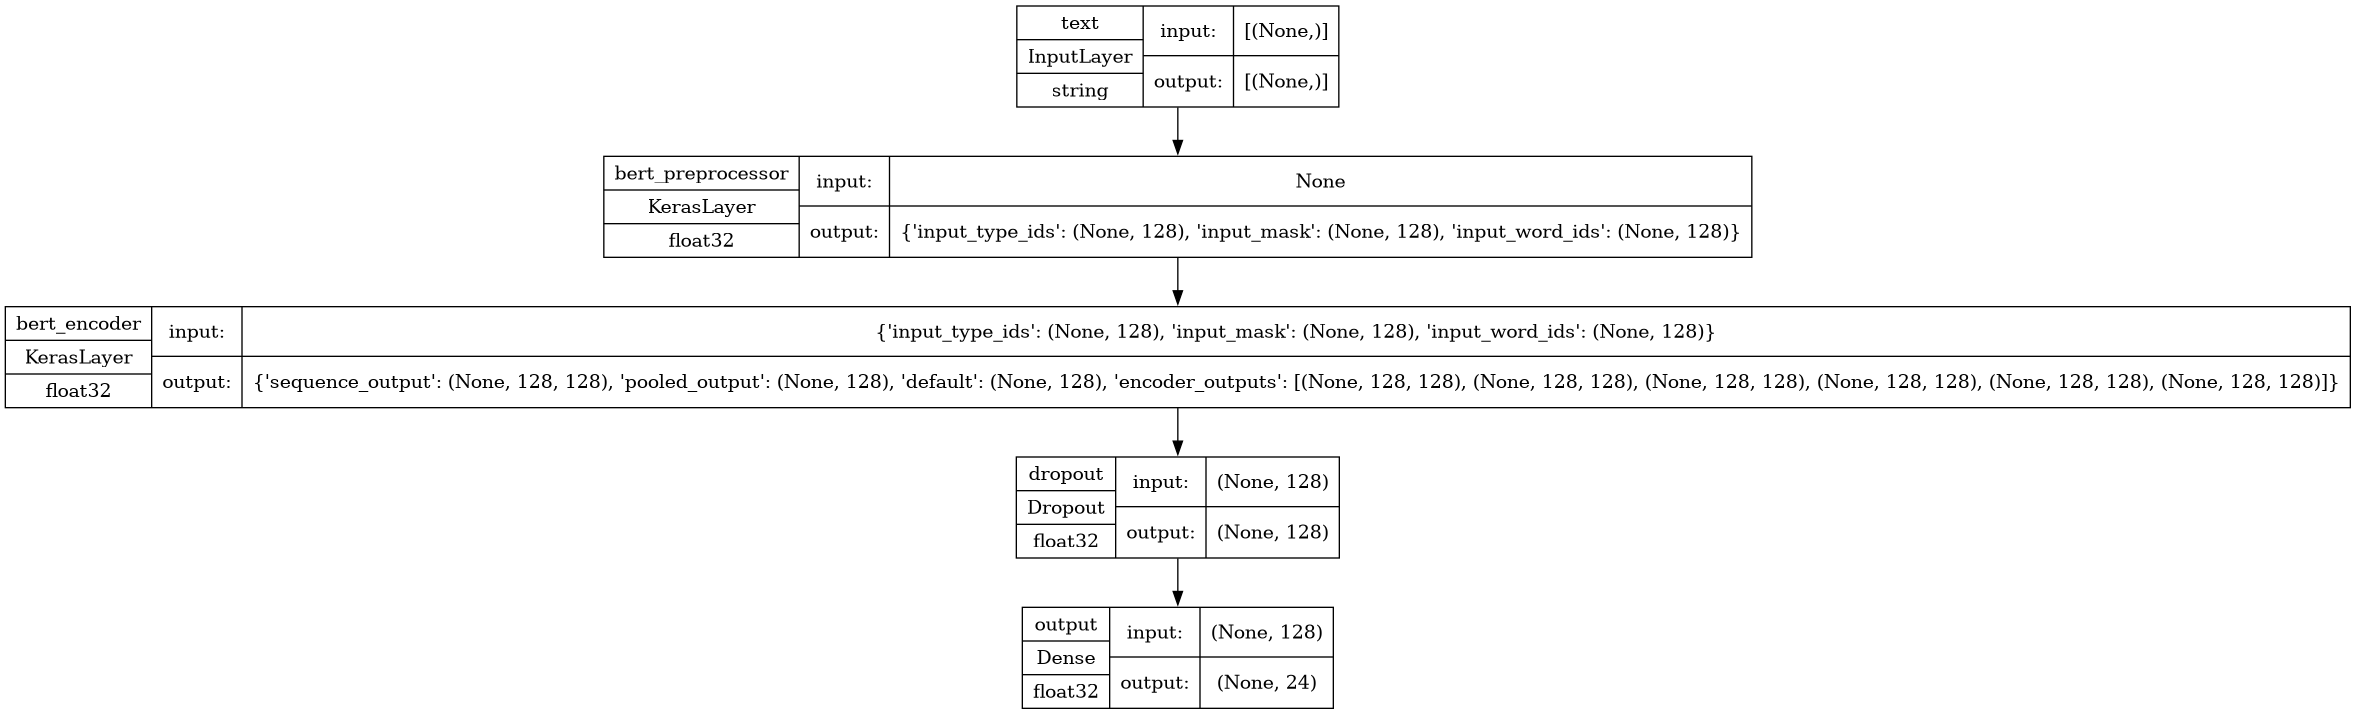

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [18]:
model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/15
15/15 [==============================] - 29s 457ms/step - loss: 3.3760 - accuracy: 0.0458 - val_loss: 3.0716 - val_accuracy: 0.1583
Epoch 2/15
15/15 [==============================] - 4s 237ms/step - loss: 2.8153 - accuracy: 0.1854 - val_loss: 2.1462 - val_accuracy: 0.4375
Epoch 3/15
15/15 [==============================] - 4s 245ms/step - loss: 1.7242 - accuracy: 0.5542 - val_loss: 1.0979 - val_accuracy: 0.7375
Epoch 4/15
15/15 [==============================] - 3s 235ms/step - loss: 0.9076 - accuracy: 0.8104 - val_loss: 0.6540 - val_accuracy: 0.8708
Epoch 5/15
15/15 [==============================] - 3s 236ms/step - loss: 0.4765 - accuracy: 0.9125 - val_loss: 0.4330 - val_accuracy: 0.8833
Epoch 6/15
15/15 [==============================] - 3s 236ms/step - loss: 0.2372 - accuracy: 0.9615 - val_loss: 0.3201 - val_accuracy: 0.9208
Epoch 7/15
15/15 [==============================] - 4s 240ms/step - loss: 0.1041 - accuracy: 0.9937 - val_loss: 0.2457 - val_accuracy: 0.9375
Epoch

# Saving the model and the classes

We now save our model in ```.keras``` format and the classes dictionary in ```.json``` format.

In [19]:
model.save('/kaggle/working/model.keras')

In [20]:
classes = label_binarizer.classes_
classes_dict = {i: v for i, v in enumerate(classes)}
with open('/kaggle/working/classes.json', 'w') as file:
    json.dump(classes_dict, file)

# Testing our Model

We now test our model using some custom inputs to check its predictions.

## The predict function

The predict function here takes text as a parameter which is the string containing the user prompt. It then creates a dictionary with a key ```text``` and the value as the entered prompt. We then convert the entered prompt into a tensor so that our model can predict the class. We finally use the ```predict``` function of our model to predict the probability (the softmax function) of all our classes and we return the top three classes with the highest probability.

In [21]:
def predict(text):
    print(text)
    feature = {'text': text}
    input_dict = {name: tf.convert_to_tensor([value]) for name, value in feature.items()}
    predictions = model.predict(input_dict, verbose=0)[0]
    classes = label_binarizer.classes_
    predictions_dict = {}
    for i in range(len(classes)):
        predictions_dict[classes[i]] = predictions[i] * 100
    predictions_dict = {k: v for k, v in sorted(predictions_dict.items(), key=lambda item: item[1], reverse=True)}
    count = 0
    for disease in predictions_dict:
        if count == 3:
            break
        print(f'{disease}: {predictions_dict[disease]}%')
        count += 1

In [22]:
predict('I inadvertently lose weight and have a hard time gaining it back. I use antacids to get rid of the pain and discomfort I experience. It aches so much in my mouth.')
print()
predict('My vision is foggy, and it appears to be growing worse. I feel exhausted and worn out all the time. I also have severe dizziness and lightheadedness on occasion.')
print()
predict('I get wheezing and breathing difficulties, which are asthma symptoms. I frequently have headaches and fever. I am continuously exhausted.')

I inadvertently lose weight and have a hard time gaining it back. I use antacids to get rid of the pain and discomfort I experience. It aches so much in my mouth.
Peptic Ulcer Disease: 99.30301308631897%
Jaundice: 0.15237558400258422%
Gastroesophageal Reflux Disease: 0.10699940612539649%

My vision is foggy, and it appears to be growing worse. I feel exhausted and worn out all the time. I also have severe dizziness and lightheadedness on occasion.
Diabetes: 99.01566505432129%
Hypertension: 0.31526326201856136%
Drug Reaction: 0.19416299182921648%

I get wheezing and breathing difficulties, which are asthma symptoms. I frequently have headaches and fever. I am continuously exhausted.
Allergy: 99.74998831748962%
Dengue: 0.037493836134672165%
Common Cold: 0.035642721923068166%


In [23]:
predict('my hands are paining')
print()

my hands are paining
Drug Reaction: 75.9118139743805%
Dengue: 6.771872192621231%
Urinary Tract Infection: 6.024805456399918%



In [24]:
# Save the model in the SavedModel format
model.save('/kaggle/working/model_saved_model')


## Bot

In [29]:
import ipywidgets as widgets
from IPython.display import display
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('/kaggle/working/model_saved_model')

# Define the classes dictionary
classes_dict = {
    0: "Acne", 1: "Allergy", 2: "Arthritis", 3: "Bronchial Asthma", 4: "Cervical Spondylosis",
    5: "Chicken Pox", 6: "Common Cold", 7: "Dengue", 8: "Diabetes", 9: "Drug Reaction",
    10: "Fungal infection", 11: "GERD", 12: "Gastroenteritis", 13: "Heart attack", 14: "Hepatitis B",
    15: "Hepatitis C", 16: "Hepatitis D", 17: "Hepatitis E", 18: "Hypertension", 19: "Hyperthyroidism",
    20: "Hypoglycemia", 21: "Hypothyroidism", 22: "Jaundice", 23: "Malaria", 24: "Migraine",
    25: "Osteoarthristis", 26: "Paralysis (brain hemorrhage)", 27: "Peptic ulcer diseae",
    28: "Pneumonia", 29: "Psoriasis", 30: "Tuberculosis", 31: "Typhoid", 32: "Urinary tract infection",
    33: "Varicose veins"
}

# Define the predict function
def predict(text):
    feature = {'text': text}
    input_dict = {name: tf.convert_to_tensor([value]) for name, value in feature.items()}
    predictions = model.predict(input_dict, verbose=0)[0]
    top_predictions = [{"disease": classes_dict[i], "probability": float(predictions[i]) * 100} for i in range(len(predictions))]
    return sorted(top_predictions, key=lambda x: x['probability'], reverse=True)[:3]  # Return top 3 predictions

# Create input and output widgets
input_text = widgets.Text(description="Input:")
output_text = widgets.HTML()

# Define function to handle input
def handle_submit(sender):
    user_input = input_text.value
    predictions = predict(user_input)
    output_text.value = ""
    for prediction in predictions:
        output_text.value += f"<p>{prediction['disease']}: {prediction['probability']:.2f}%</p>"

# Attach handle_submit function to input widget
input_text.on_submit(handle_submit)

# Display widgets
display(input_text)
display(output_text)


Text(value='', description='Input:')

HTML(value='')